## 1. Data Preparing

Thực hiện load dữ liệu time series tổng hợp từ **file_name**, chuẩn hóa dữ liệu, và trích features.

In [1]:
import numpy as np
import math
from datetime import timedelta
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import utils
import utils_cl

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# Load data
file_name = "normal_data.csv"
summary_df = pd.read_csv("processed_data/" + file_name)
summary_df['IMPORT_KWH_SHIFT1'] = summary_df.groupby("MA_DIEMDO").MILESTONE_IMPORT_KWH.shift(1)
summary_df['CONSUMPTION'] = summary_df.MILESTONE_IMPORT_KWH - summary_df.IMPORT_KWH_SHIFT1
summary_df = summary_df.rename(columns = {"index" : "TIME"})
summary_df.TIME = pd.to_datetime(summary_df.TIME)

summary_df = summary_df[['TIME', 'MA_DIEMDO', 'CONSUMPTION']]

In [3]:
summary_df.head()

,TIME,MA_DIEMDO,CONSUMPTION
0,2017-01-01 06:00:00,PP01000100340001,NaN
1,2017-01-01 12:00:00,PP01000100340001,0.913215
2,2017-01-01 18:00:00,PP01000100340001,1.725953
3,2017-01-02 00:00:00,PP01000100340001,1.071990
4,2017-01-02 06:00:00,PP01000100340001,1.071990


In [32]:
# Extract features
df_monthly, list_normal_mdd = utils_cl.extract_n_months(summary_df, 1, True)
#df_monthly.to_csv("processed_data/cluster_normal_data.csv", encoding='utf-8', index=False)

In [6]:
print(df_monthly.shape)
df_monthly.tail()

(983, 17)


,index,MA_DIEMDO,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
978,995,PP07000670496001,0.163460,0.122452,0.159352,0.204797,0.264355,0.244083,0.173682,0.246507,0.182639,0.236500,0.178845,0.157682,0.145092,0.136505,0.148306
979,996,PP03000840215001,1.810743,1.821003,1.965159,2.276603,2.567051,3.011029,2.652720,3.078603,2.779886,2.307515,2.198229,1.909264,2.023040,2.024914,2.047616
980,997,PP07000711382001,2.158110,2.100246,2.215214,3.161024,3.178750,3.843851,3.793786,5.578964,3.166059,2.330447,2.032782,2.198324,1.877059,2.284520,3.135608
981,998,PP09000800592001,3.447920,3.082495,3.017207,3.926898,5.398045,6.633417,5.173168,6.324120,5.929511,4.324661,3.054072,2.682591,2.472876,3.341252,2.858925
982,999,PP05000523336001,1.744017,2.038061,2.388474,2.256872,2.299805,2.469385,2.341295,2.745995,2.503442,1.982606,1.847509,1.764762,1.719063,1.631941,1.754708


## 2. Visualizing Data

## 3. Clustering Implementation (Centroid Idea Process)

 Khung process : **Áp dụng cho các thuật toán Hard - Clustering** <br> 
* Chuẩn hóa dữ liệu đầu vào
* Thực hiện 1 thuật toán phân cụm cho tập dữ liệu đầu vào (Xét dữ liệu đầu vào bị mixed và chưa đc dán nhãn)
* Đưa ra Output : danh sách các cluster và tập các center tương ứng
* Với mỗi Cluster : tính khoảng cách trung bình từ các điểm trong đến tâm -> *average radius* với mỗi Cluster
* Thực hiện kiểm tra bất thường với một *new input* : <br> 
> 1. Đặt một mốc *thres* (~ 1.0-) để scale các *average radius*
> 2. Tính khoảng cách từ *new input* đến các Cluster, có thể ĐN : kc từ *new input* đến tâm Cluster
> 3. So sánh kc này ứng với *(average radius)* x *thres*, nếu đều lớn hơn với tất cả các Cluster thì cho là abnormal



In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

X = df_monthly.iloc[:, 2:].values
m = X.shape[0] # number of samples
n = X.shape[1] # number of features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)
#X_normalized = X_scaled

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(X_normalized)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [8]:
# Split normal set into train set and test set
X_normalized_train = X_normalized.sample(frac = 0.8, random_state = 0)
X_normalized_test = X_normalized.drop(X_normalized_train.index)

In [9]:
X_normalized_train.shape

(786, 15)

In [10]:
#Clustering
# Distance using : Euclidean or DTW

distance_used = utils_cl.distance_ED
#distance_used = utils_cl.distance_DTW

n_iters = 500
cluster_number = 3
Clustering_result_1, centroid_1 = utils_cl.K_Mean(np.array(X_normalized_train), n_iters, cluster_number, metric = 'euclidean')

def square(_list):
    return [_ele * _ele for _ele in _list]
average_radius = []
for i, cent in enumerate(centroid_1) :
    s = 0
    for _p in Clustering_result_1[i+1]:
        EDist_cluster_p2c = distance_used(cent, _p)
        s += EDist_cluster_p2c
    s = s / (len(Clustering_result_1[i+1]))
    average_radius.append(s)

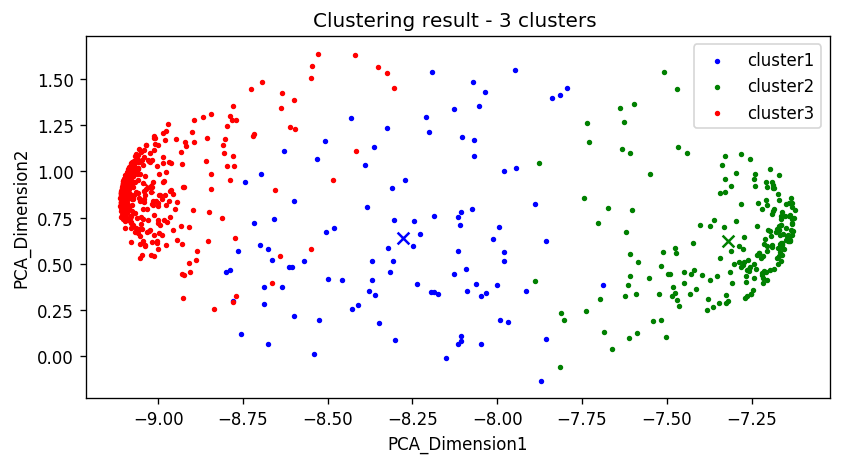

In [11]:
pca_plot = PCA(n_components=2)
principalComponents = pca_plot.fit(X)
X_principal = pca_plot.fit_transform(X)
result_2D = {}
i = 0
centroid_2D = []
for _item in Clustering_result_1 :
    result_2D[_item] = []
    for _point in Clustering_result_1[_item]:
        result_2D[_item].append(principalComponents.transform([_point])[0])
    centroid_2D.append(principalComponents.transform([centroid_1[i]])[0])
    i+= 1

def centroid_plt2D(result, cluster_number, centroid):

    plt.figure(figsize = (8, 4), dpi = 120)
    if cluster_number > 7:
        colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    else :
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    labels=['cluster' + str(i+1) for i in range(cluster_number)]
    
    for k in range(cluster_number):
        d1 = [result[k+1][i][0] for i in range(len(result[k+1]))]
        d2 = [result[k+1][i][1] for i in range(len(result[k+1]))]
        plt.scatter(d1, d2, c=colors[k], s=5, label=labels[k])
        plt.scatter(centroid[k][0], centroid[k][1], s=50, c=colors[k], marker = "x")
    #plt.scatter([_cent[0] for _cent in centroid], [_cent[1] for _cent in centroid], s=60, c='yellow', marker = 'o', label='Centroids')
    plt.xlabel('PCA_Dimension1')
    plt.ylabel('PCA_Dimension2')
    plt.title("Clustering result - " + str(cluster_number) + " clusters ")
    plt.legend()
    plt.show()
centroid_plt2D(result_2D, cluster_number, centroid_2D)

In [1]:
# Visualizing Distribution of each Cluster
dict_DC = {}
for i in range(cluster_number):
    list_distance_cluster_i = []
    for _p in Clustering_result_1[i+1]:
        list_distance_cluster_i.append(distance_used(centroid_1[i], _p))
    dict_DC[i+1] = list_distance_cluster_i
    
def distribution_plotting(cluster_number, is_print_individual = False):
    if cluster_number > 7:
        colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    else :
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    if is_print_individual : 
        for i in range(cluster_number):
            plt.figure(figsize = (4, 2), dpi = 120)
            sns.distplot(dict_DC[i+1])
            plt.title("Distribution of Distance to Center"  + str(i+1))
        
    plt.figure(figsize = (6, 3), dpi = 120)
    for i in range(cluster_number):
        sns.kdeplot(dict_DC[i+1], label="cluster" + str(i+1), color = colors[i])
    plt.legend();
    plt.title("Distribution of Distance to center in Training set")
distribution_plotting(cluster_number, False)

NameError: name 'cluster_number' is not defined

In [13]:
# Fraud Data Preaparing
test_df = X_normalized_test

test_df2 = pd.read_csv("processed_data/data_fraud_meter.csv")
test_df2= utils.large_change_handling(test_df2)
test_df2 = utils.normalize_data_frequency(test_df2)
test_df2['IS_FRAUD'] = True
test_df2.reset_index(inplace=True)
test_df2['IMPORT_KWH_SHIFT1'] = test_df2.groupby("MA_DIEMDO").MILESTONE_IMPORT_KWH.shift(1)
test_df2['CONSUMPTION'] = test_df2.MILESTONE_IMPORT_KWH - test_df2.IMPORT_KWH_SHIFT1
test_df2 = test_df2.rename(columns = {"index" : "TIME"})
test_df2.TIME = pd.to_datetime(test_df2.TIME)
test_df2, list_fraud_mdd = utils_cl.extract_n_months(test_df2, 1, True)

/home/cpc/utils.py:44: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  diemdo_df = diemdo_df.set_index("NEAREST_HOUR").loc[time_index]


In [15]:
len(list_fraud_mdd)

60

In [16]:
test_df2 = scaler.transform(test_df2.iloc[:, 2:])
test_df2 = normalize(test_df2)
test_df2 = pd.DataFrame(test_df2)

In [17]:
normal_df_test_splitted = test_df
fraud_df_test = test_df2

In [41]:
# Predicting
def test_mdd_fraud(test_mdd, thresh_hold_KM = 1.0):
    # ED_test2c : distance from test_mdd to each center
    ED_test2c = [distance_used(test_mdd, _cent) for _cent in centroid_1 ]
    #thresh_hold_KM = .75
    distance_cent_th = [_dis*thresh_hold_KM for _dis in average_radius]
    result_is_fraud = [ a > b for (a,b) in zip(distance_cent_th, ED_test2c)]
    return [ a < b for (a,b) in zip(distance_cent_th, ED_test2c)]


def prediction_result(test_set, list_mdd, thresh_KM = 1.0):
    total_correct = 0
    N = test_set.shape[0]
    predicted_normal = []
    for i in range(N):
        try:
            test_mdd_i = test_set.iloc[i, :]
        except :
            print("Fail - ", i)
        if sum(test_mdd_fraud(test_mdd_i, thresh_KM)) == cluster_number :
            total_correct += 1
        else :
            predicted_normal.append(list_mdd[i])
        #print(test_mdd_fraud(test_mdd_i, thresh_KM))

    print("Total fraud predicted      : ", total_correct )
    print("Total test samples         : ", N)
    print(total_correct/N)
    return predicted_normal

In [54]:
thresh_KM = 0.90

#test_set = normal_df_test_splitted
#list_mdd = list_normal_mdd

test_set = fraud_df_test
list_mdd = list_fraud_mdd

predicted_normal = prediction_result(test_set, list_mdd, thresh_KM)

Total fraud predicted      :  43
Total test samples         :  60
0.7166666666666667


In [27]:
fraud_predicted_wrong

['PP01000621525001',
 'PP05000501075001',
 'PP05000515674001',
 'PP07000683751001',
 'PP09000808816001',
 'PP09000837585001',
 'PP09000821975001',
 'PP07000684209001',
 'PP07000682085001',
 'PP03000832565001',
 'PP07000613734001',
 'PP05000504291001',
 'PP07000713473001']

In [339]:
### 1 time running
## thresh_hold_KM = 1.00
# 3 - 30/47  (0.63)
# 5 - 26/47  (0.55)
# 10 - 29/47 (0.62)

## thresh_hold_KM = 0.8
# 3 - 38/47  (0.81)
# 5 - 39/47  (0.82)
# 10 - 39/47 90.83

In [ ]:
## thresh_hold_KM = 1.0
# Fraud_test
# 3 - 26/47
# 5 - 30/47
# 10 - 30/47
# Normal_test (frac = 0.9)
# 3 -------
# 5 - 34/85
# 10- 29/35

# Normal_test (frac = 0.8)
# 3 - 37/170
# 5 - 63/170
# 10- 68/170

## 3'. Clustering Implementation ( Neighbours-eps Idea Process )

In [17]:
# Clustering
from sklearn.cluster import DBSCAN
# DBSCAN
eps = 0.097
min_samples = 5
labels_1 = utils_cl._DBSCAN(X_principal, eps, min_samples)

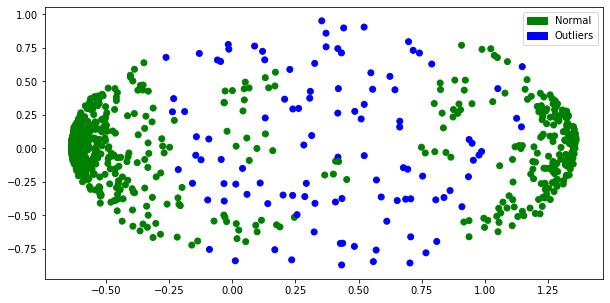

Number of clusters :  10
Number of outliers :  107
Number of clustered points :  742


In [18]:
## Visualizing Result
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Using PCA for visualizing only

def plotting_DBSCAN(labels):
    
    colors_normal = 'g'
    colors_outlier = 'b'
    cvec = []
    n_outliers = 0
    for _lab in labels:
        if _lab != -1 :
            cvec.append(colors_normal)
        else :
            cvec.append(colors_outlier)
            n_outliers += 1

    plt.figure(figsize =(10, 5))
    plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)
    # Building the legend
    patch_1 = mpatches.Patch(color='g', label='Normal')
    patch_2 = mpatches.Patch(color='b', label='Outliers')

    plt.legend(handles=[patch_1, patch_2])
    plt.show()

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)
    print("Number of clusters : ", n_clusters_)
    print("Number of outliers : ", n_outliers)
    print("Number of clustered points : ", len(labels) - n_outliers)
    
plotting_DBSCAN(labels_1)